# This notebook is about using EV sector tickers from 1/1/ 2024 to 8/31/2024, leveraging Chronos prediction to get prediction of daily price from 9/1/2024 to 9/30/2024.

## Import Dependencies

In [4]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-c2ga_xr7
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-c2ga_xr7
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 133761a90145f77971a08c49bfc7cca318b2df9b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import torch


Processing Rivian Automotive (RIVN):
Date
2024-01-02    21.10
2024-01-03    20.32
2024-01-04    19.50
2024-01-05    19.08
2024-01-08    19.58
Name: Close, dtype: float64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

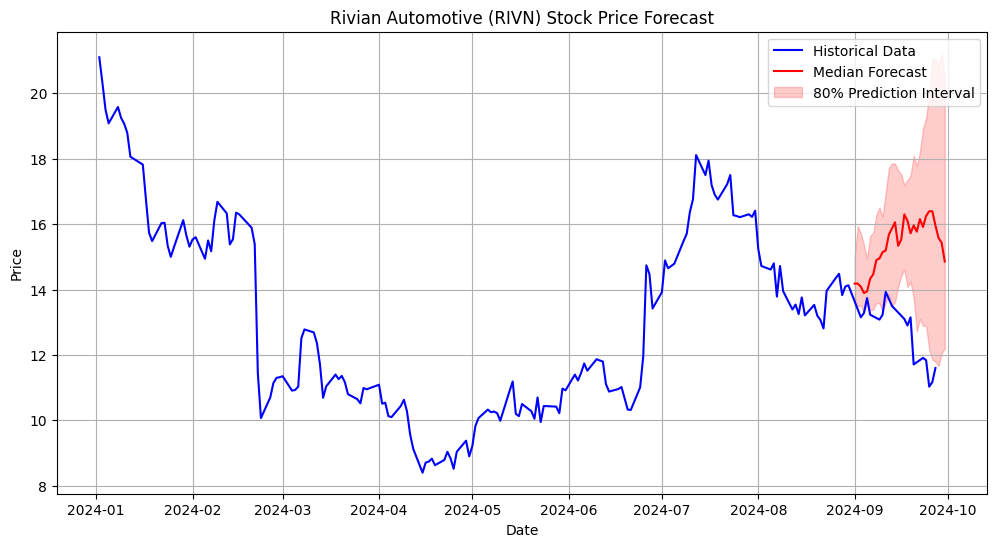

Mean Absolute Scaled Error (MASE): 7.4848
Weighted Quantile Loss (WQL): 0.9563

Processing Tesla (TSLA):
Date
2024-01-02    248.419998
2024-01-03    238.449997
2024-01-04    237.929993
2024-01-05    237.490005
2024-01-08    240.449997
Name: Close, dtype: float64


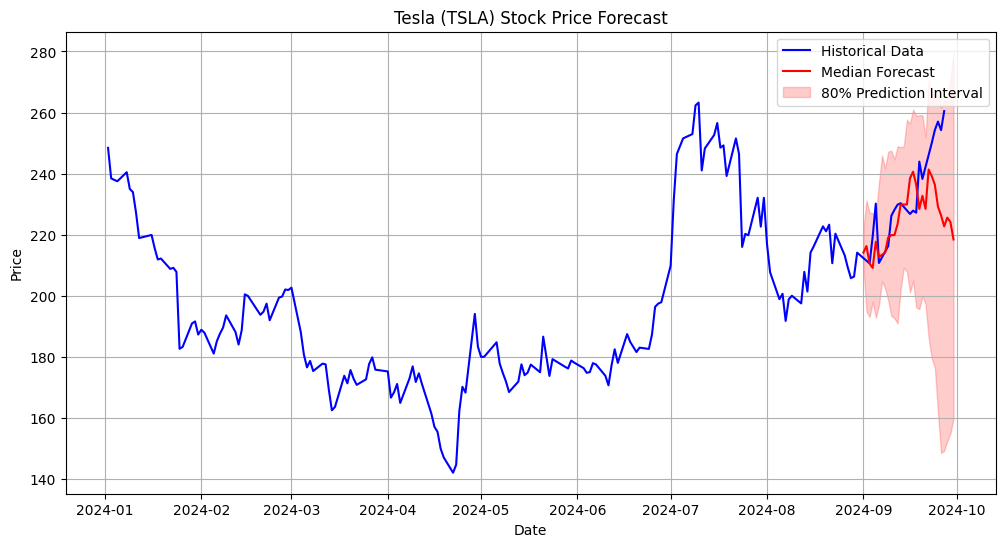

Mean Absolute Scaled Error (MASE): 1.8765
Weighted Quantile Loss (WQL): 4.4170

Processing Nio Inc Adr (NIO):
Date
2024-01-02    8.42
2024-01-03    8.50
2024-01-04    8.27
2024-01-05    8.06
2024-01-08    7.93
Name: Close, dtype: float64


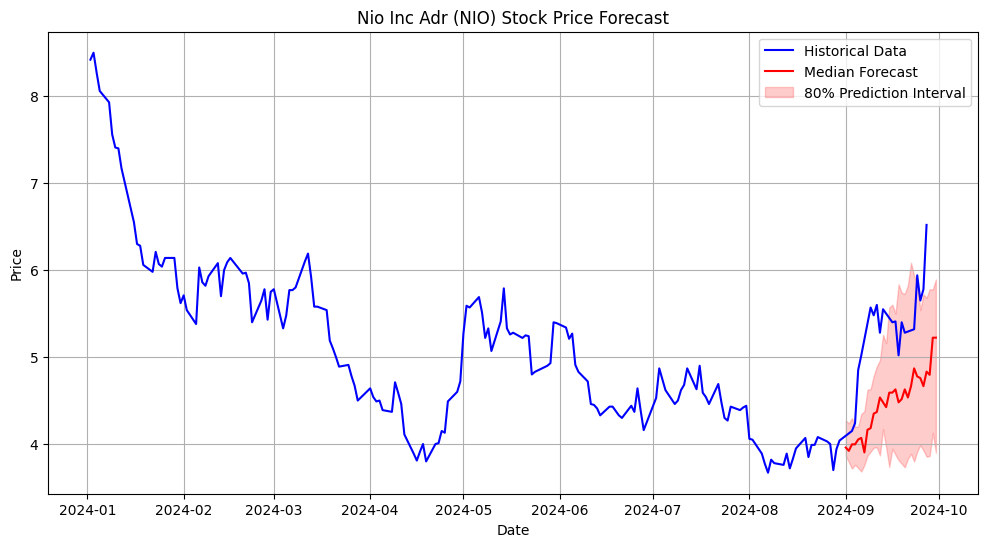

Mean Absolute Scaled Error (MASE): 3.1050
Weighted Quantile Loss (WQL): 0.4402

Processing Xpeng A Adr (XPEV):
Date
2024-01-02    14.04
2024-01-03    14.23
2024-01-04    13.79
2024-01-05    13.09
2024-01-08    12.70
Name: Close, dtype: float64


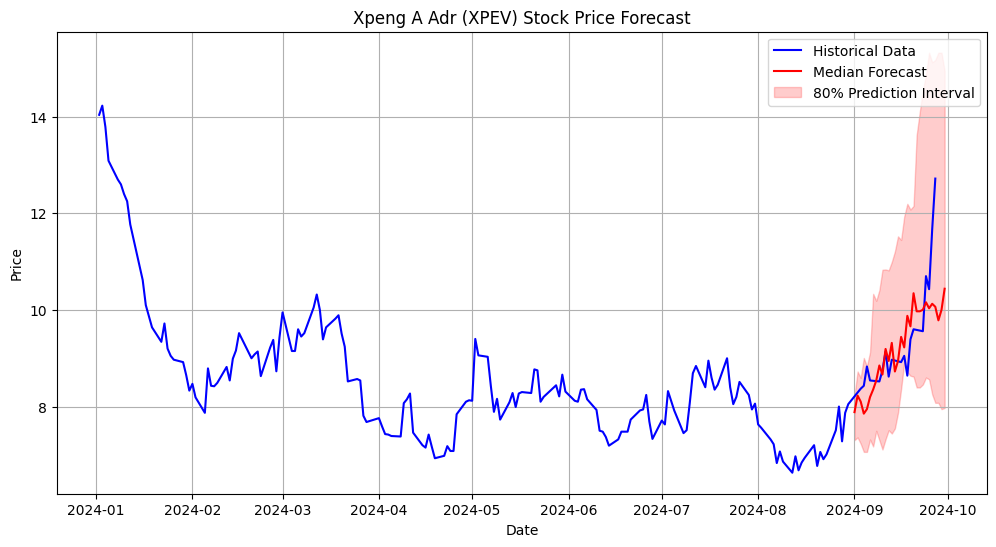

Mean Absolute Scaled Error (MASE): 1.4733
Weighted Quantile Loss (WQL): 0.2795

Processing Evgo Inc (EVGO):
Date
2024-01-02    3.30
2024-01-03    3.14
2024-01-04    3.13
2024-01-05    3.09
2024-01-08    3.19
Name: Close, dtype: float64


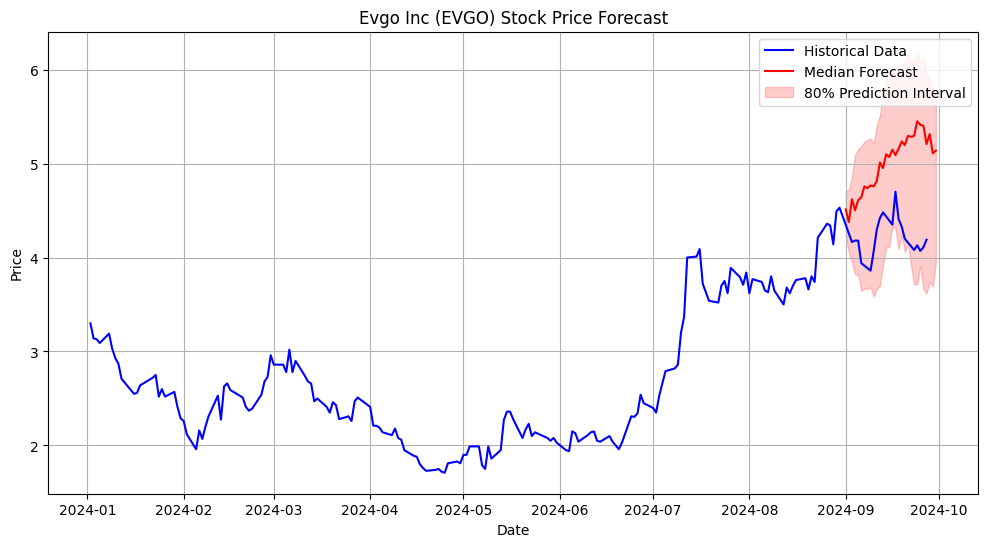

Mean Absolute Scaled Error (MASE): 6.2605
Weighted Quantile Loss (WQL): 0.2165

Processing Li Auto Adr (LI):
Date
2024-01-02    34.590000
2024-01-03    35.740002
2024-01-04    35.110001
2024-01-05    34.160000
2024-01-08    34.000000
Name: Close, dtype: float64


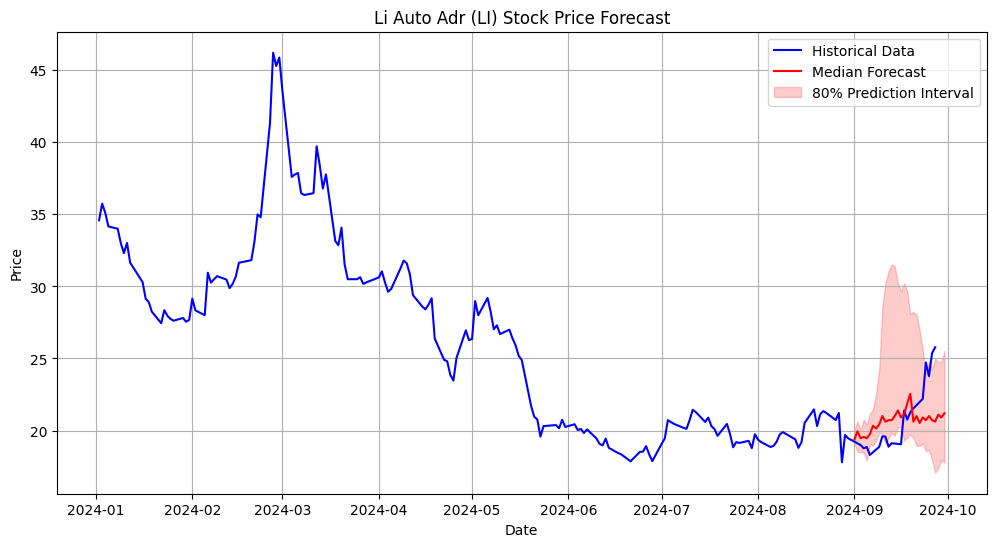

Mean Absolute Scaled Error (MASE): 2.4679
Weighted Quantile Loss (WQL): 0.5131

Processing Indie Semiconductor Inc Class A (INDI):
Date
2024-01-02    7.58
2024-01-03    7.35
2024-01-04    7.07
2024-01-05    7.08
2024-01-08    7.51
Name: Close, dtype: float64


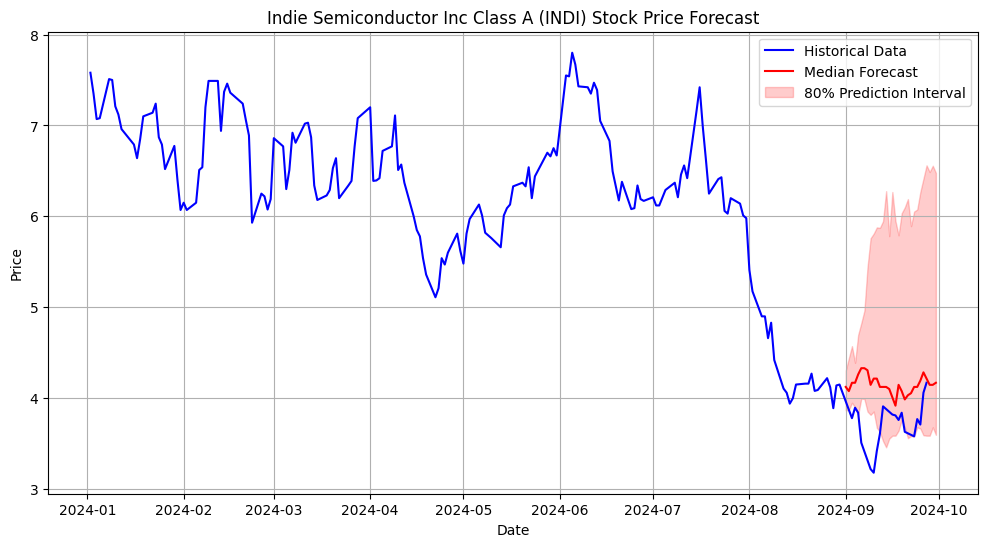

Mean Absolute Scaled Error (MASE): 2.8545
Weighted Quantile Loss (WQL): 0.2070

Processing Chargepoint Holdings Inc Class A (CHPT):
Date
2024-01-02    2.17
2024-01-03    2.06
2024-01-04    2.11
2024-01-05    2.23
2024-01-08    2.23
Name: Close, dtype: float64


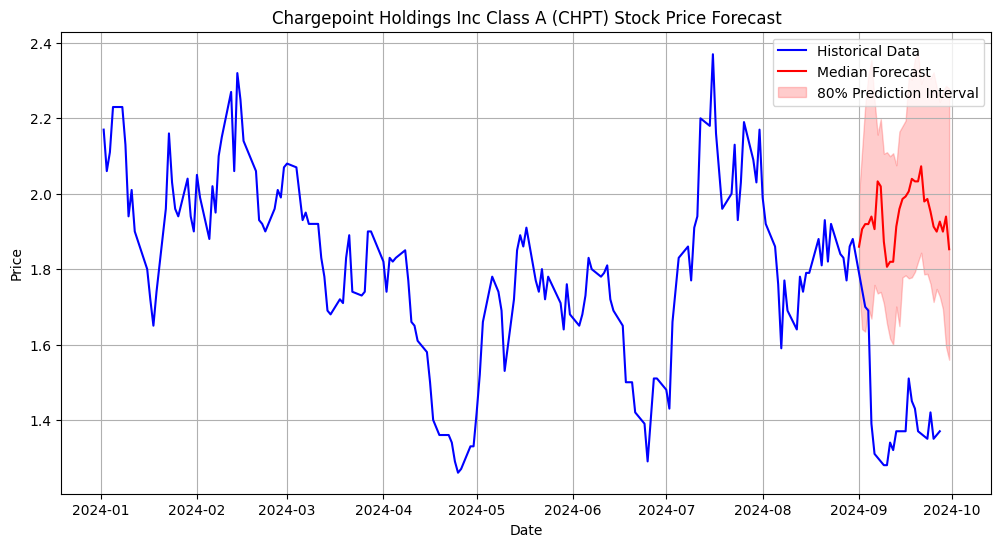

Mean Absolute Scaled Error (MASE): 9.4140
Weighted Quantile Loss (WQL): 0.2319

Processing Lucid Group Inc (LCID):
Date
2024-01-02    4.15
2024-01-03    3.96
2024-01-04    3.89
2024-01-05    3.78
2024-01-08    3.80
Name: Close, dtype: float64


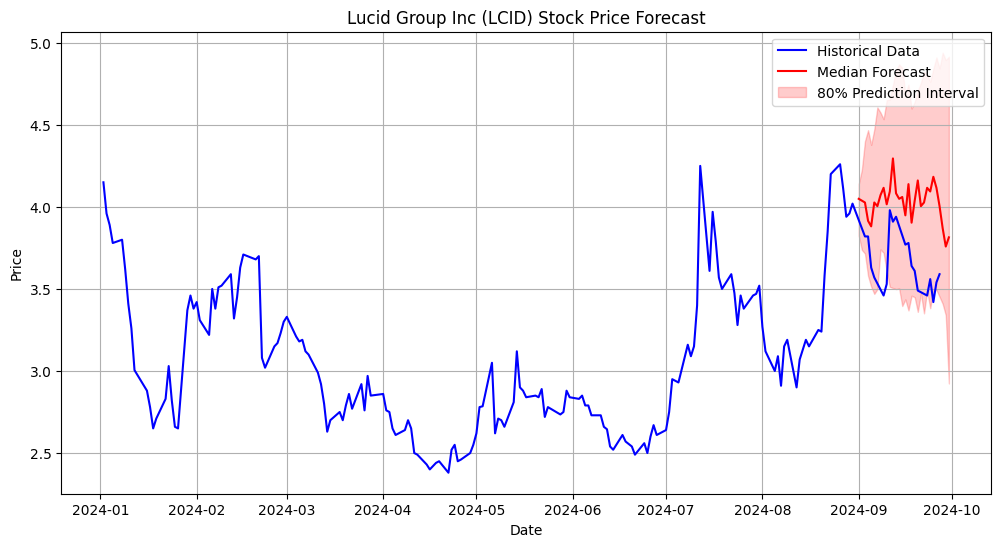

Mean Absolute Scaled Error (MASE): 3.8298
Weighted Quantile Loss (WQL): 0.1273

Processing Luminar Technologies A (LAZR):
Date
2024-01-02    46.799999
2024-01-03    44.700001
2024-01-04    45.450001
2024-01-05    49.049999
2024-01-08    49.650002
Name: Close, dtype: float64


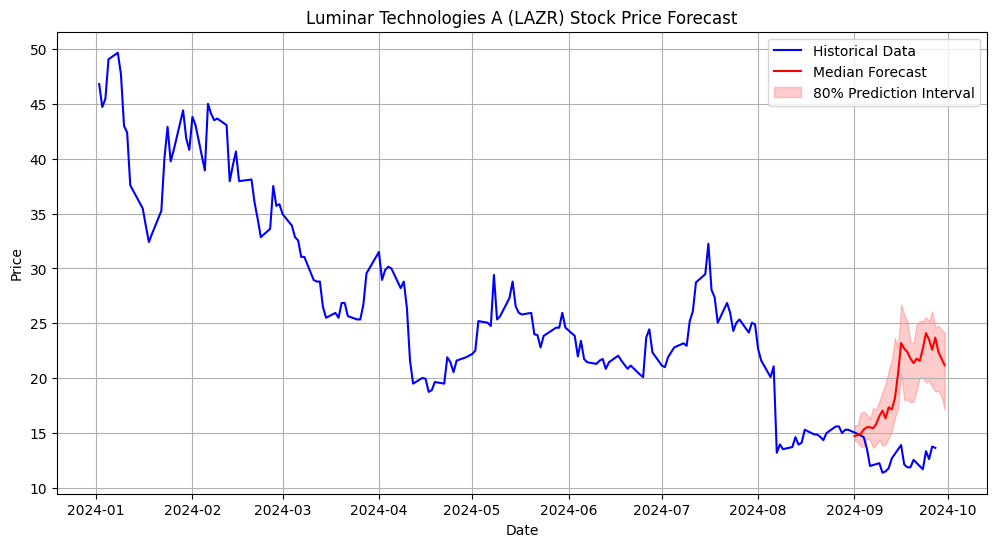

Mean Absolute Scaled Error (MASE): 9.1593
Weighted Quantile Loss (WQL): 2.1010


In [6]:
companies = [
    ("Rivian Automotive", "RIVN"),
    ("Tesla", "TSLA"),
    ("Nio Inc Adr", "NIO"),
    ("Xpeng A Adr", "XPEV"),
    ("Evgo Inc", "EVGO"),
    ("Li Auto Adr", "LI"),
    ("Indie Semiconductor Inc Class A", "INDI"),
    ("Chargepoint Holdings Inc Class A", "CHPT"),
    ("Lucid Group Inc", "LCID"),
    ("Luminar Technologies A", "LAZR")
]

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.index = df.index.tz_localize(None)
    return df['Close']

def calculate_mase(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    naive_mae = np.mean(np.abs(actual.values[1:] - actual.values[:-1]))
    return mae / naive_mae

def calculate_wql(actual, forecast_array):
    quantiles = np.linspace(0.1, 0.9, 9)
    wql_scores = []

    forecast_array_trimmed = forecast_array[:, :len(actual)]

    for q in quantiles:
        quantile_forecast = np.percentile(forecast_array_trimmed, q * 100, axis=0)
        error = np.maximum(q * (actual - quantile_forecast), (q - 1) * (actual - quantile_forecast))
        wql_scores.append(np.mean(error))

    return np.mean(wql_scores)

def process_company(company_name, ticker):
    print(f"\nProcessing {company_name} ({ticker}):")

    start_date = "2024-01-01"
    end_date = "2024-08-31"
    forecast_start = "2024-09-01"
    forecast_end = "2024-09-30"

    all_stock = get_stock_data(ticker, start_date, forecast_end)
    stock = get_stock_data(ticker, start_date, end_date)
    print(stock.head())

    stock_pipeline = ChronosPipeline.from_pretrained(
        'amazon/chronos-t5-small',
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

    context = torch.tensor(stock.values).unsqueeze(0)

    stock_forecast = stock_pipeline.predict(
        context=context,
        prediction_length=30,
        num_samples=12,
    )

    forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, tz=None)
    forecast_array = stock_forecast.numpy().squeeze()

    median_forecast = np.median(forecast_array, axis=0)
    lower_bound = np.percentile(forecast_array, 10, axis=0)
    upper_bound = np.percentile(forecast_array, 90, axis=0)

    stock_forecast_df = pd.DataFrame({
        'Median Forecast': median_forecast,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound
    }, index=forecast_dates)

    plt.figure(figsize=(12, 6))
    plt.plot(all_stock.index, all_stock.values, label='Historical Data', color='blue')
    plt.plot(stock_forecast_df.index, stock_forecast_df['Median Forecast'], label='Median Forecast', color='red')
    plt.fill_between(stock_forecast_df.index,
                     stock_forecast_df['Lower Bound'],
                     stock_forecast_df['Upper Bound'],
                     color='red', alpha=0.2, label='80% Prediction Interval')
    plt.title(f'{company_name} ({ticker}) Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    actual_forecast = all_stock[forecast_start:forecast_end]
    mase = calculate_mase(actual_forecast, stock_forecast_df['Median Forecast'])
    wql = calculate_wql(actual_forecast.values, forecast_array)

    print(f"Mean Absolute Scaled Error (MASE): {mase:.4f}")
    print(f"Weighted Quantile Loss (WQL): {wql:.4f}")

    return {
        'Company': f"{company_name} ({ticker})",
        'MASE': mase,
        'WQL': wql
    }

results = [process_company(name, ticker) for name, ticker in companies]


Processing Rivian Automotive (RIVN):
Date
2024-01-02    21.10
2024-01-03    20.32
2024-01-04    19.50
2024-01-05    19.08
2024-01-08    19.58
Name: Close, dtype: float64


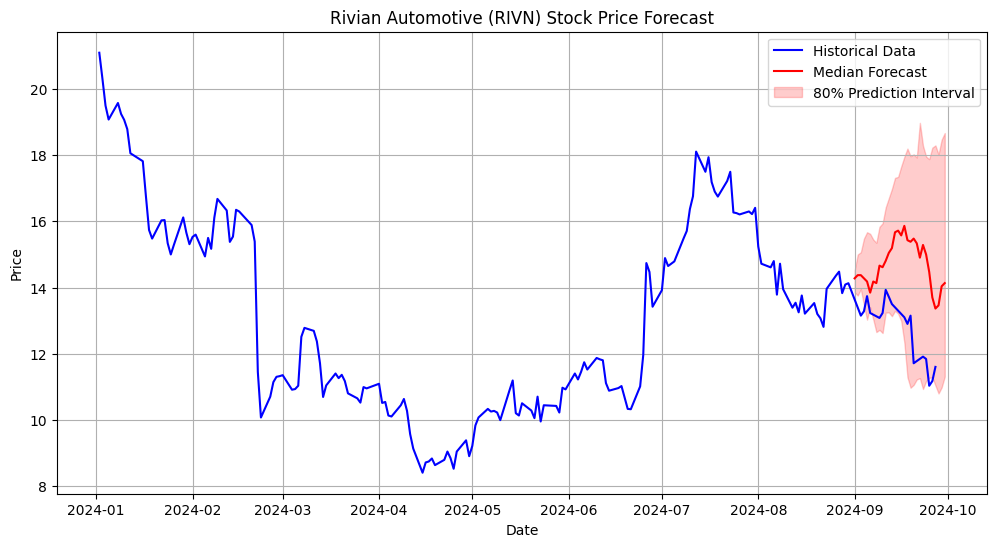

Mean Absolute Scaled Error (MASE): 5.5772
Weighted Quantile Loss (WQL): 0.7573

Processing Tesla (TSLA):
Date
2024-01-02    248.419998
2024-01-03    238.449997
2024-01-04    237.929993
2024-01-05    237.490005
2024-01-08    240.449997
Name: Close, dtype: float64


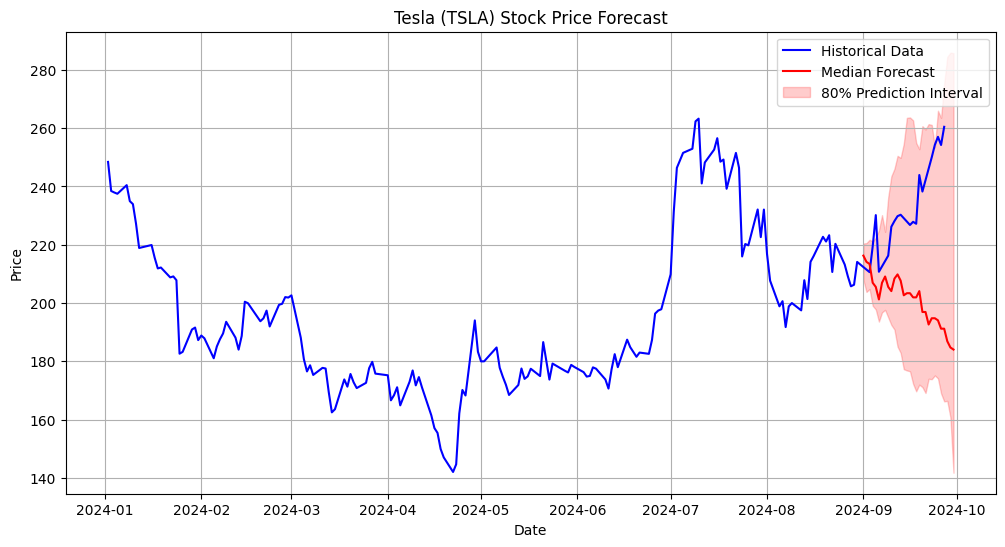

Mean Absolute Scaled Error (MASE): 5.0690
Weighted Quantile Loss (WQL): 9.9778

Processing Nio Inc Adr (NIO):
Date
2024-01-02    8.42
2024-01-03    8.50
2024-01-04    8.27
2024-01-05    8.06
2024-01-08    7.93
Name: Close, dtype: float64


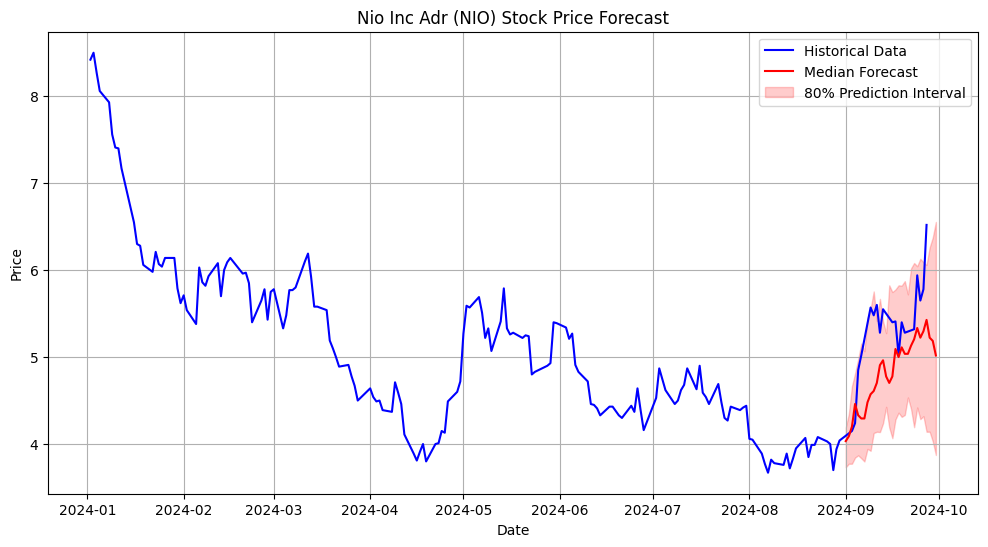

Mean Absolute Scaled Error (MASE): 1.7601
Weighted Quantile Loss (WQL): 0.2709

Processing Xpeng A Adr (XPEV):
Date
2024-01-02    14.04
2024-01-03    14.23
2024-01-04    13.79
2024-01-05    13.09
2024-01-08    12.70
Name: Close, dtype: float64


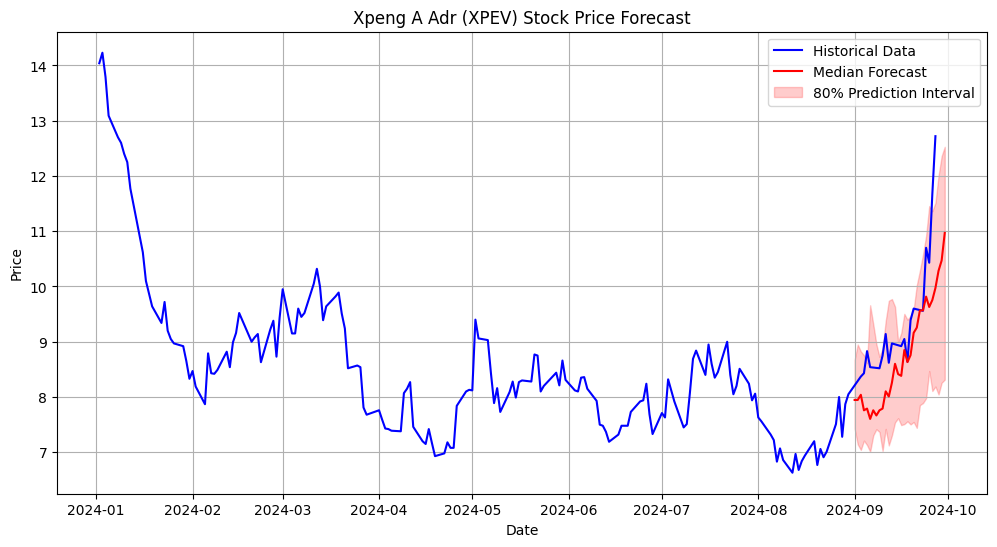

Mean Absolute Scaled Error (MASE): 1.9107
Weighted Quantile Loss (WQL): 0.5262

Processing Evgo Inc (EVGO):
Date
2024-01-02    3.30
2024-01-03    3.14
2024-01-04    3.13
2024-01-05    3.09
2024-01-08    3.19
Name: Close, dtype: float64


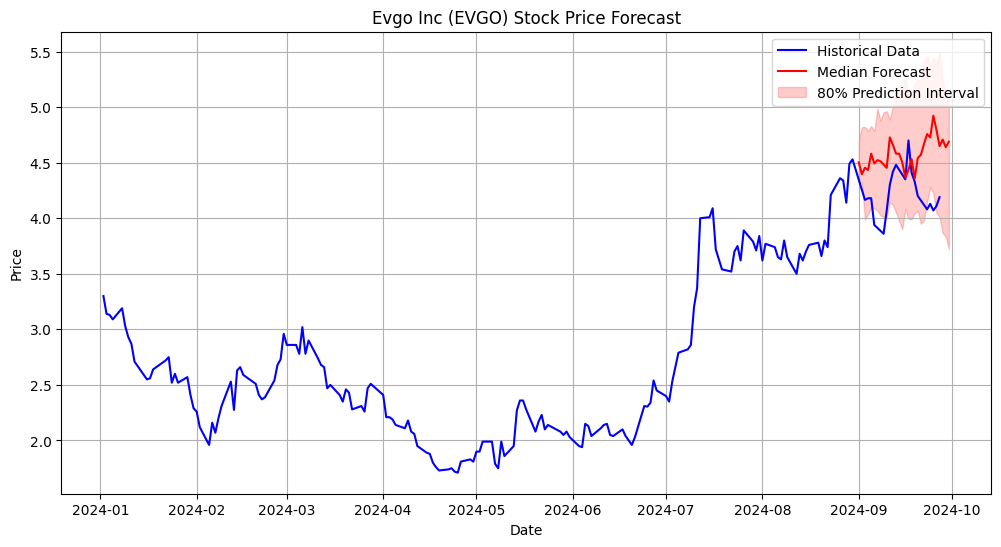

Mean Absolute Scaled Error (MASE): 3.0342
Weighted Quantile Loss (WQL): 0.1108

Processing Li Auto Adr (LI):
Date
2024-01-02    34.590000
2024-01-03    35.740002
2024-01-04    35.110001
2024-01-05    34.160000
2024-01-08    34.000000
Name: Close, dtype: float64


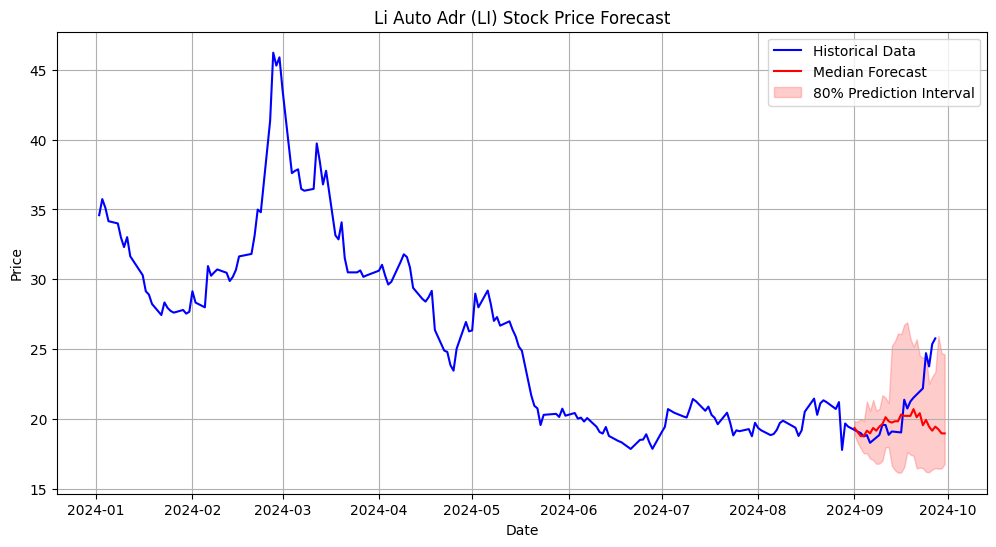

Mean Absolute Scaled Error (MASE): 2.3958
Weighted Quantile Loss (WQL): 0.6560

Processing Indie Semiconductor Inc Class A (INDI):
Date
2024-01-02    7.58
2024-01-03    7.35
2024-01-04    7.07
2024-01-05    7.08
2024-01-08    7.51
Name: Close, dtype: float64


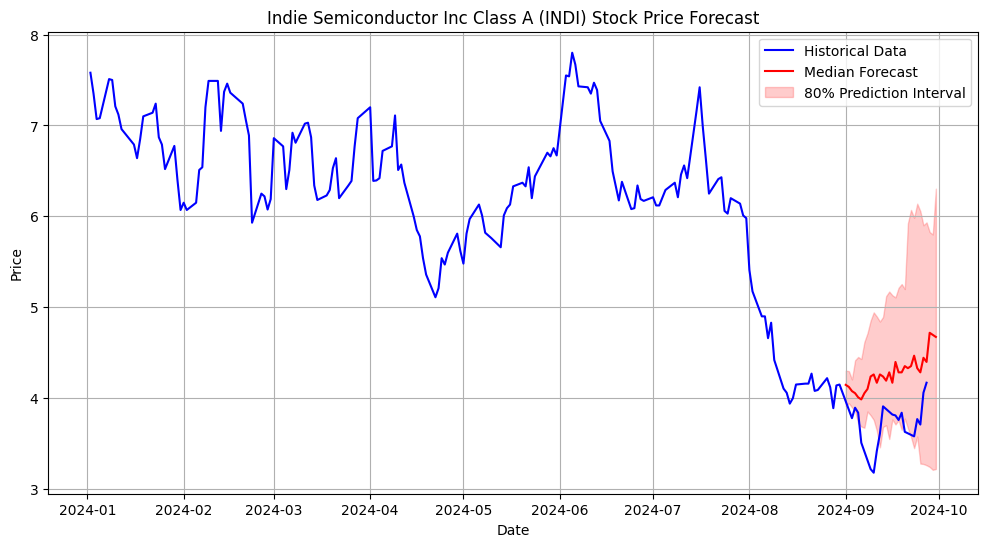

Mean Absolute Scaled Error (MASE): 3.4993
Weighted Quantile Loss (WQL): 0.1901

Processing Chargepoint Holdings Inc Class A (CHPT):
Date
2024-01-02    2.17
2024-01-03    2.06
2024-01-04    2.11
2024-01-05    2.23
2024-01-08    2.23
Name: Close, dtype: float64


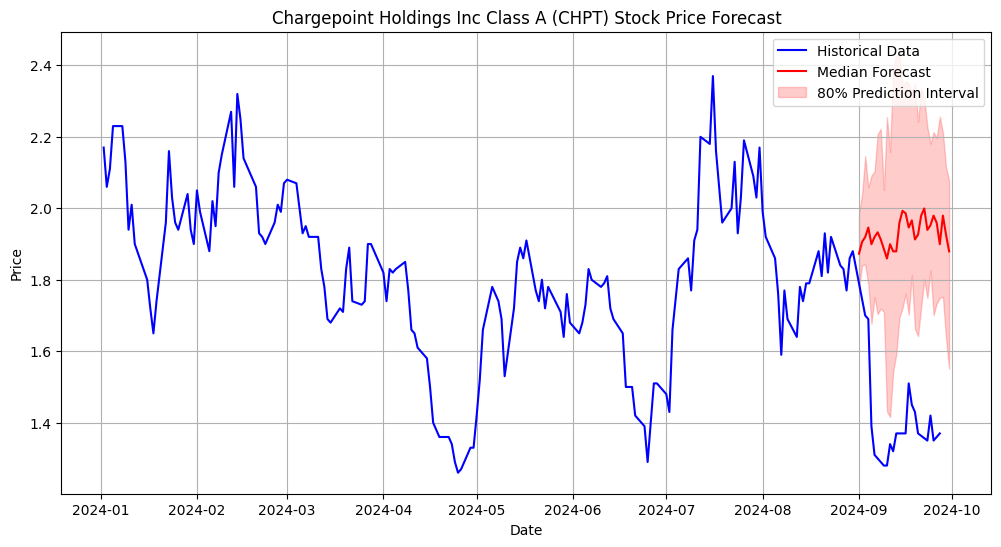

Mean Absolute Scaled Error (MASE): 9.2827
Weighted Quantile Loss (WQL): 0.2240

Processing Lucid Group Inc (LCID):
Date
2024-01-02    4.15
2024-01-03    3.96
2024-01-04    3.89
2024-01-05    3.78
2024-01-08    3.80
Name: Close, dtype: float64


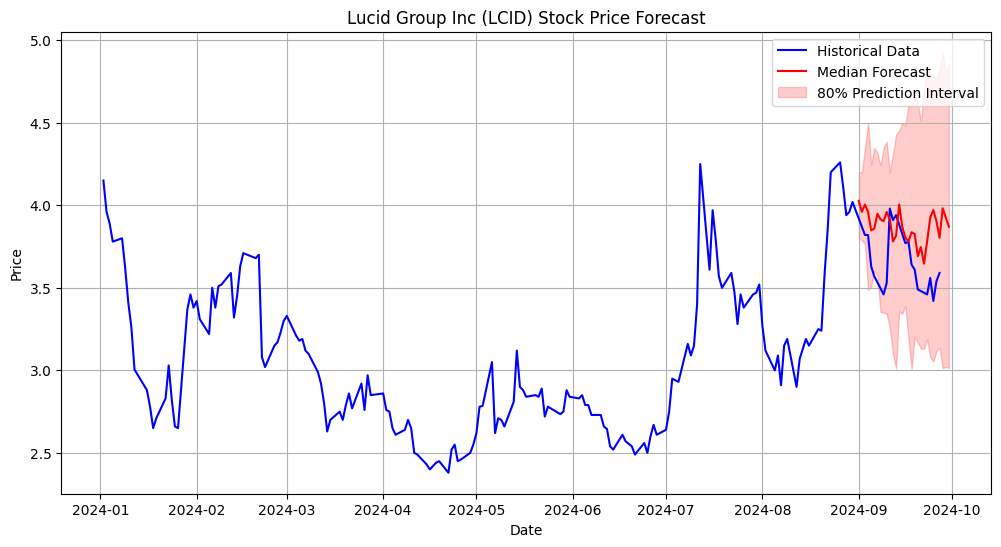

Mean Absolute Scaled Error (MASE): 2.2495
Weighted Quantile Loss (WQL): 0.0926

Processing Luminar Technologies A (LAZR):
Date
2024-01-02    46.799999
2024-01-03    44.700001
2024-01-04    45.450001
2024-01-05    49.049999
2024-01-08    49.650002
Name: Close, dtype: float64


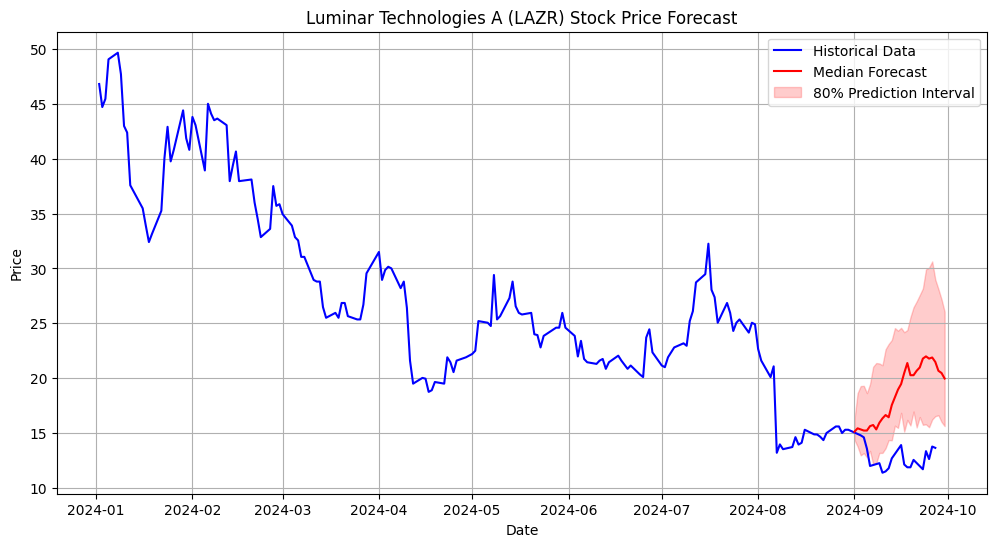

Mean Absolute Scaled Error (MASE): 7.8616
Weighted Quantile Loss (WQL): 1.7880

Summary of Results:
                                   Company      MASE       WQL
0                 Rivian Automotive (RIVN)  5.577192  0.757289
1                             Tesla (TSLA)  5.069042  9.977768
2                        Nio Inc Adr (NIO)  1.760098  0.270919
3                       Xpeng A Adr (XPEV)  1.910729  0.526243
4                          Evgo Inc (EVGO)  3.034237  0.110826
5                         Li Auto Adr (LI)  2.395824  0.656021
6   Indie Semiconductor Inc Class A (INDI)  3.499312  0.190062
7  Chargepoint Holdings Inc Class A (CHPT)  9.282686  0.224042
8                   Lucid Group Inc (LCID)  2.249530  0.092605
9            Luminar Technologies A (LAZR)  7.861624  1.787965

Companies Ranked by MASE (Best to Worst):
                                   Company      MASE
2                        Nio Inc Adr (NIO)  1.760098
3                       Xpeng A Adr (XPEV)  1.910729
8    

In [7]:
results = []
for company_name, ticker in companies:
    result = process_company(company_name, ticker)
    results.append(result)

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)

best_performers = results_df.sort_values('MASE')
print("\nCompanies Ranked by MASE (Best to Worst):")
print(best_performers[['Company', 'MASE']])

In [8]:
chronos_results_df = pd.DataFrame(results)
print("\nSummary of Results:")
chronos_results_df


Summary of Results:


,Company,MASE,WQL
0,Rivian Automotive (RIVN),5.577192,0.757289
1,Tesla (TSLA),5.069042,9.977768
2,Nio Inc Adr (NIO),1.760098,0.270919
3,Xpeng A Adr (XPEV),1.910729,0.526243
4,Evgo Inc (EVGO),3.034237,0.110826
5,Li Auto Adr (LI),2.395824,0.656021
6,Indie Semiconductor Inc Class A (INDI),3.499312,0.190062
7,Chargepoint Holdings Inc Class A (CHPT),9.282686,0.224042
8,Lucid Group Inc (LCID),2.249530,0.092605
9,Luminar Technologies A (LAZR),7.861624,1.787965


# Compare the forecasting accuracy of Chronos with at least two traditional methods


Processing Rivian Automotive (RIVN):


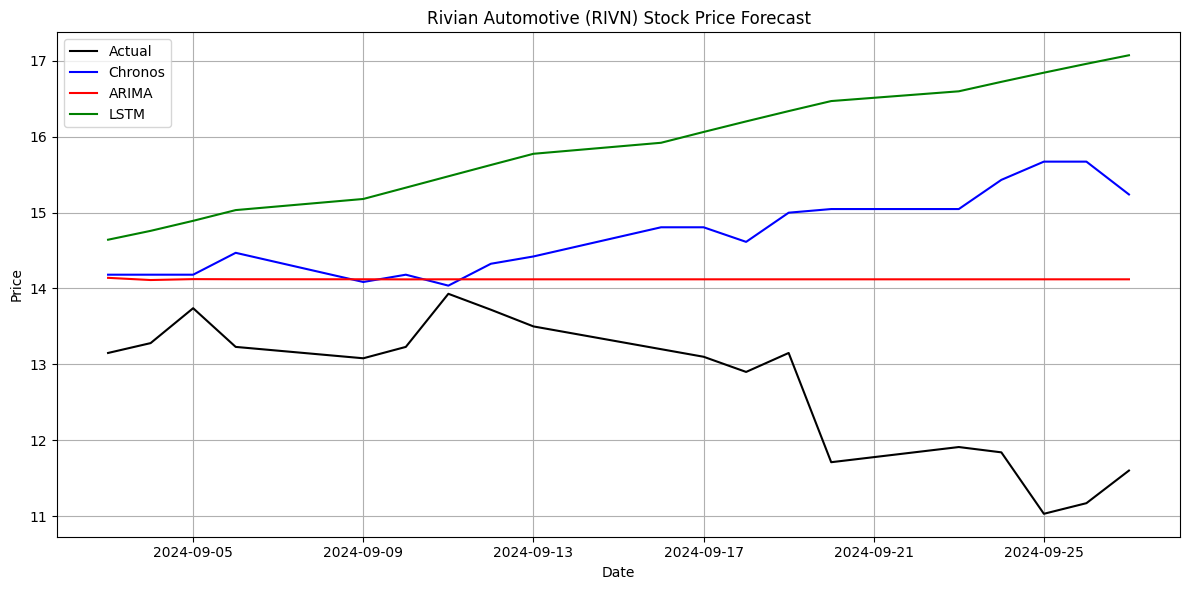


Processing Tesla (TSLA):


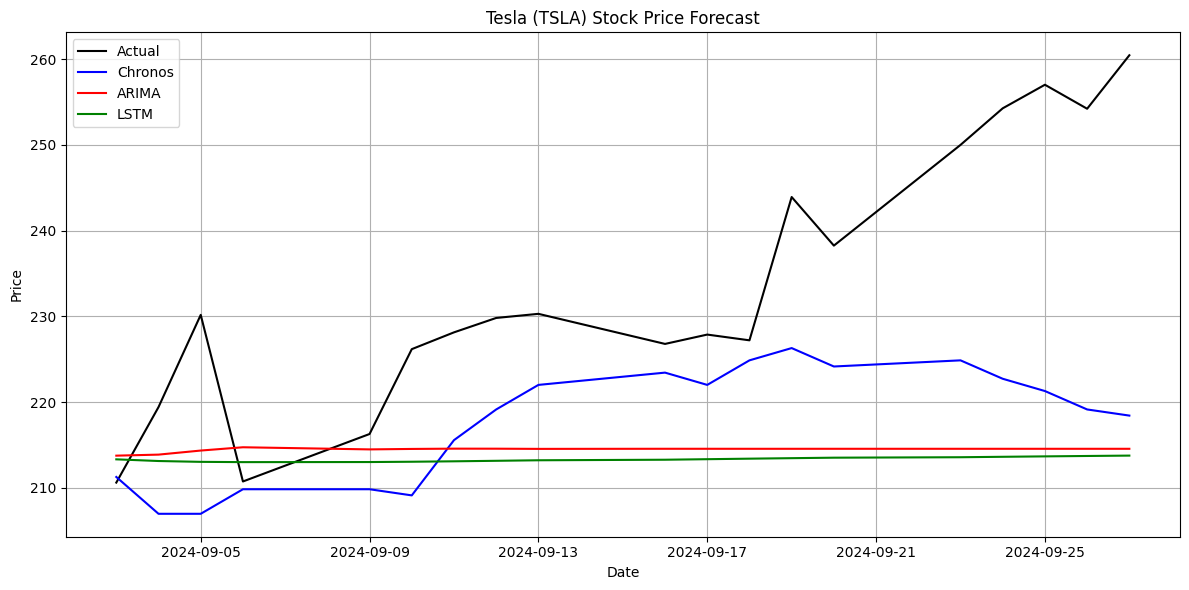


Processing Nio Inc Adr (NIO):


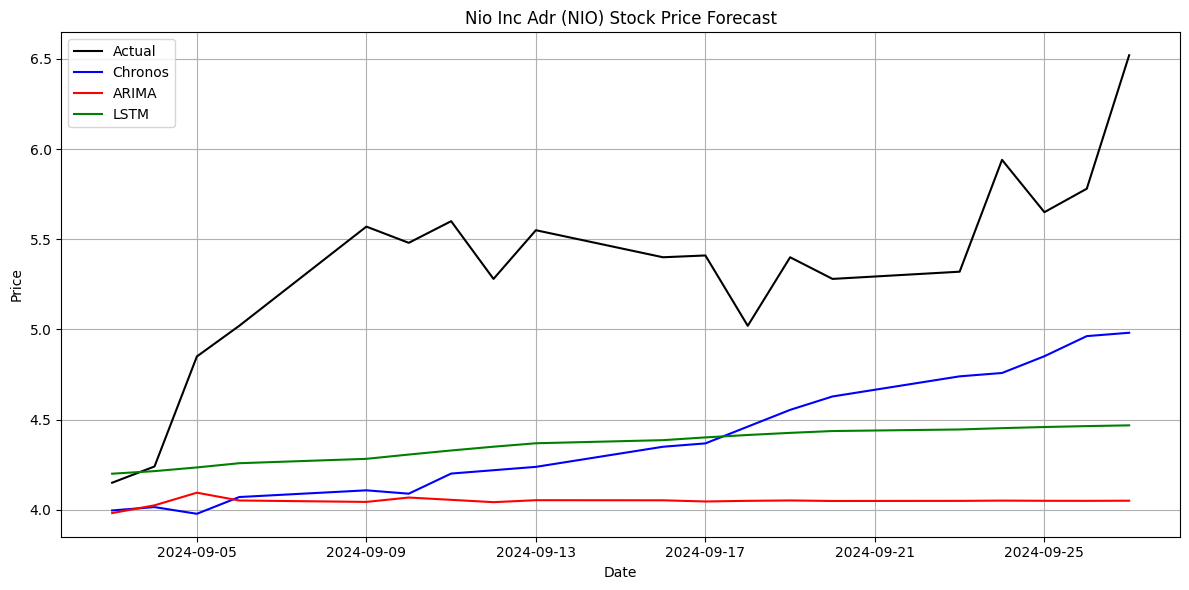


Processing Xpeng A Adr (XPEV):


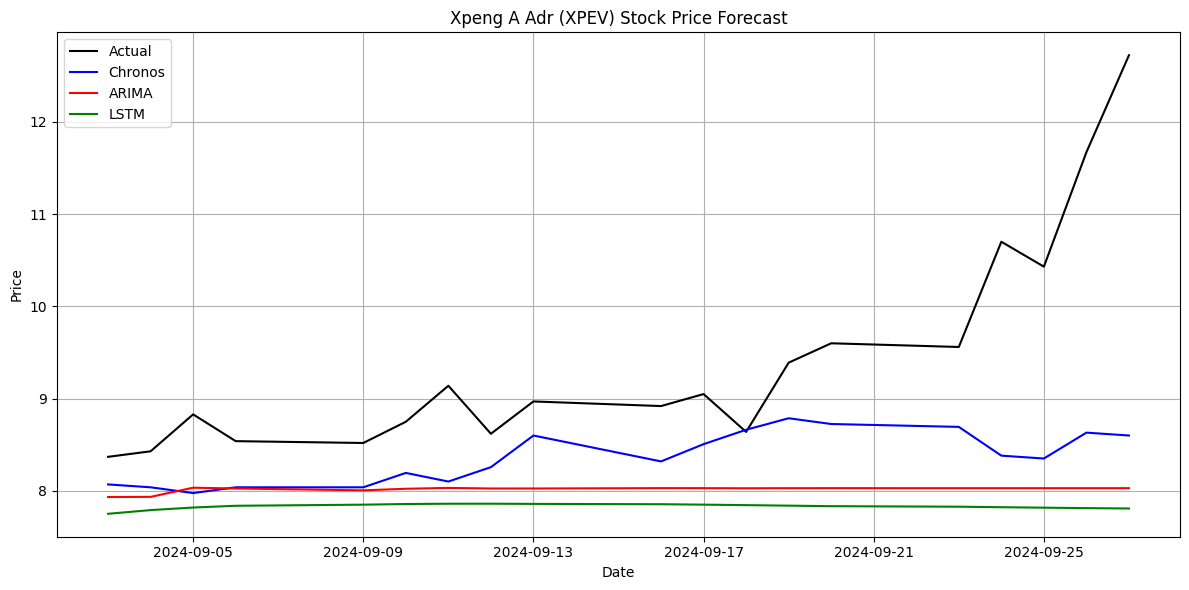


Processing Evgo Inc (EVGO):


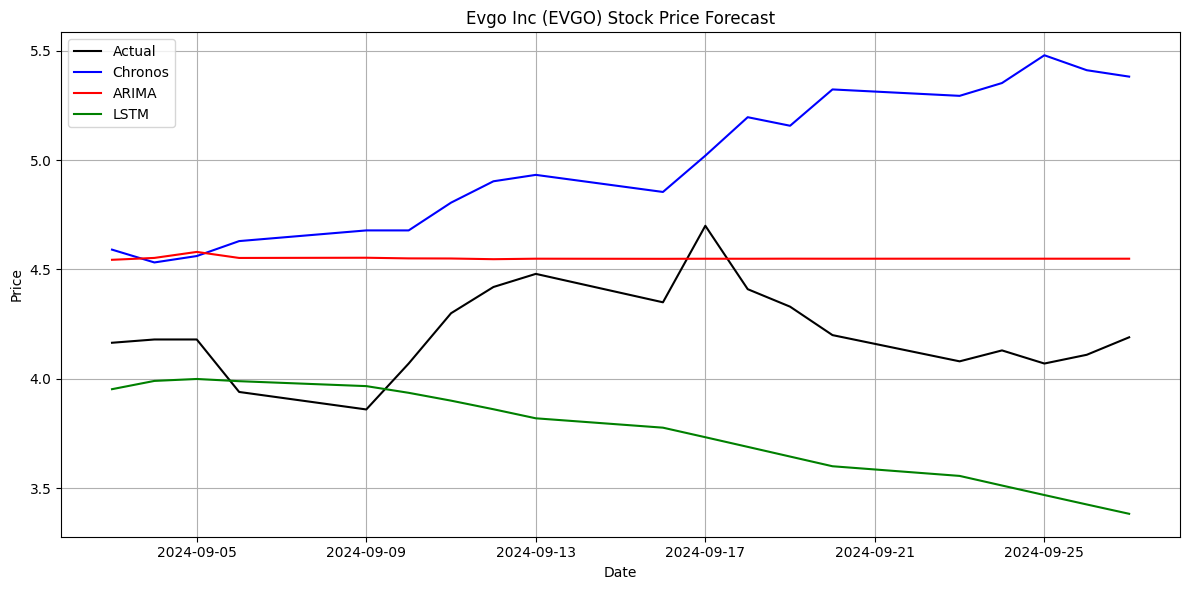


Processing Li Auto Adr (LI):


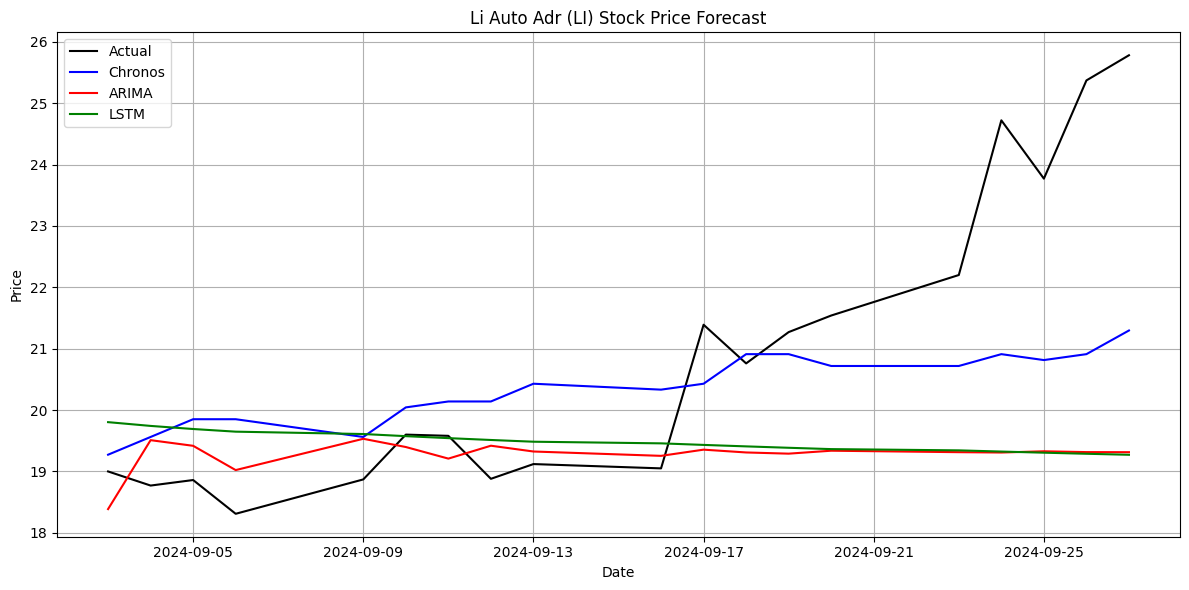


Processing Indie Semiconductor Inc Class A (INDI):


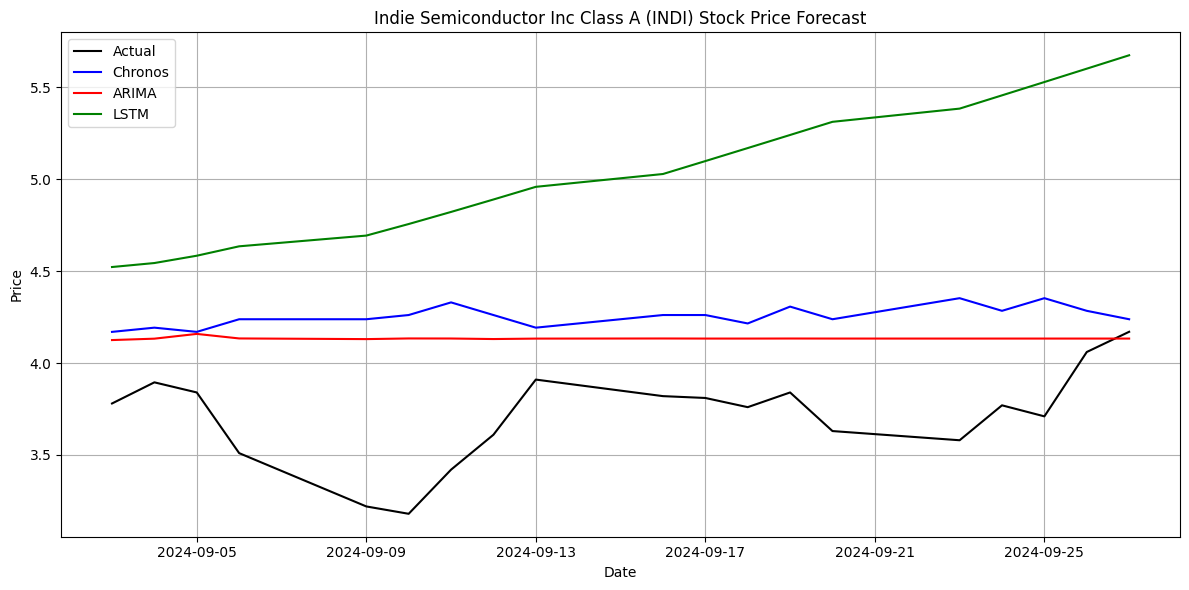


Processing Chargepoint Holdings Inc Class A (CHPT):


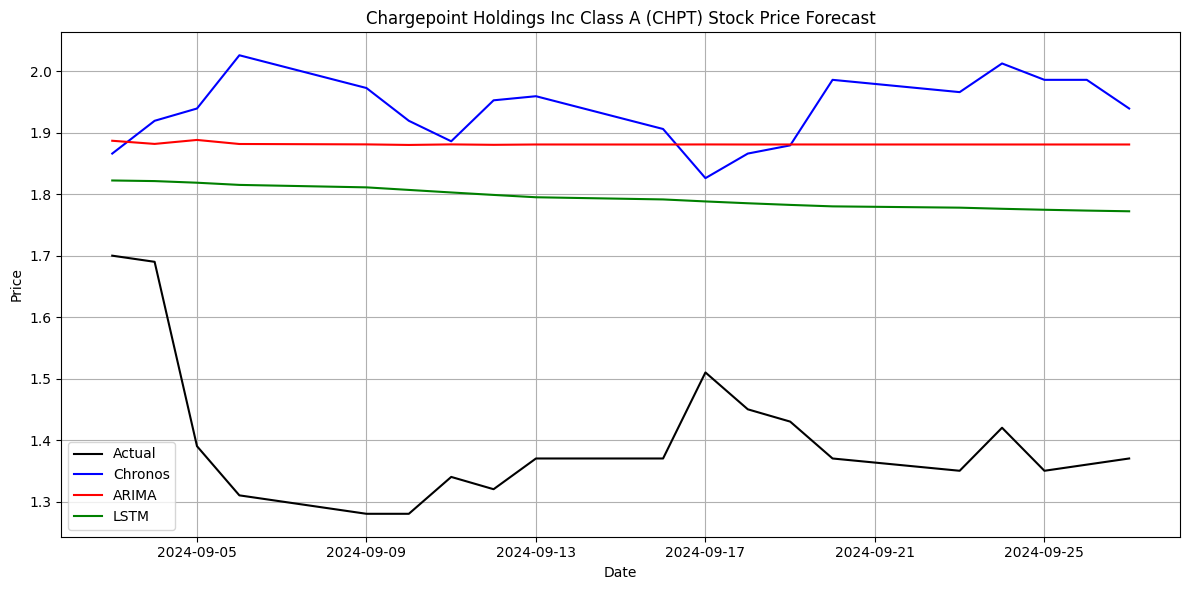


Processing Lucid Group Inc (LCID):


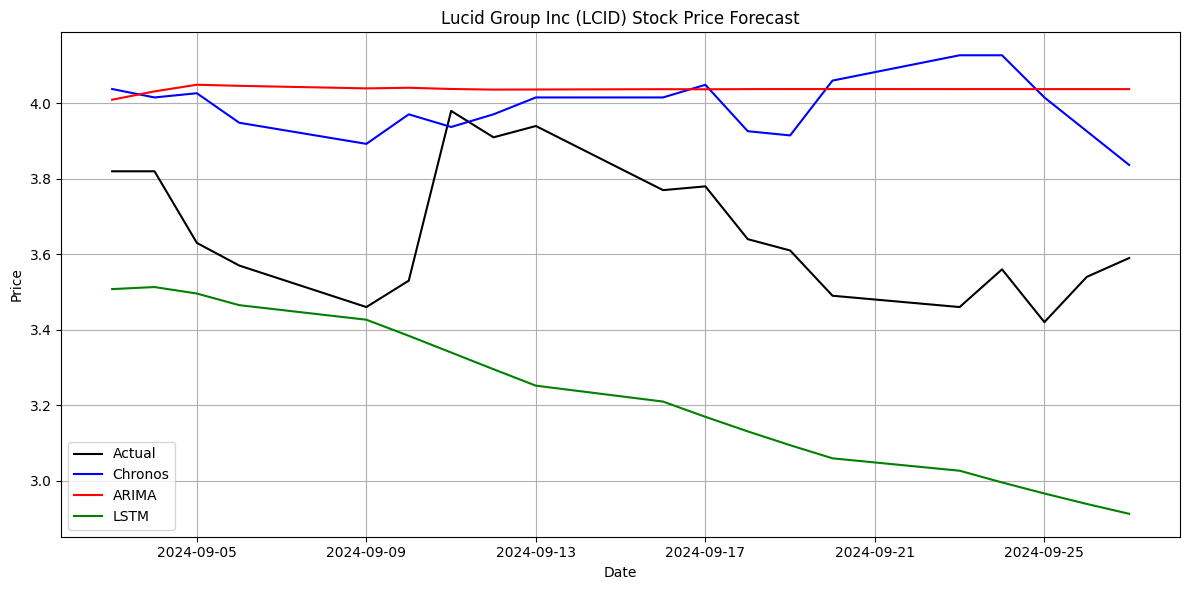


Processing Luminar Technologies A (LAZR):


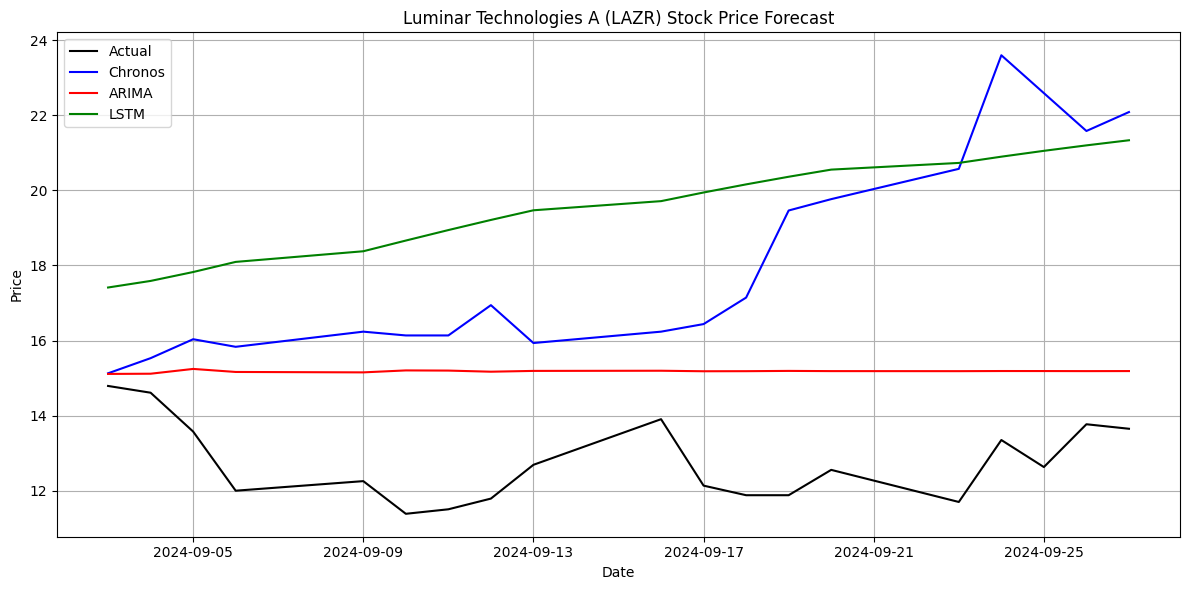


Summary of Results:
                            Company  Chronos_MASE  Chronos_WQL  ARIMA_MASE  \
0                 Rivian Automotive      5.408251     0.971983    3.783467   
1                             Tesla      2.534734     8.029469    3.165777   
2                       Nio Inc Adr      3.329907     0.470812    4.568843   
3                       Xpeng A Adr      2.497448     0.523770    3.324436   
4                          Evgo Inc      6.062026     0.384770    2.741121   
5                       Li Auto Adr      2.073277     0.753291    2.733118   
6   Indie Semiconductor Inc Class A      3.546494     0.271898    2.780709   
7  Chargepoint Holdings Inc Class A      9.507739     0.266745    8.527697   
8                   Lucid Group Inc      3.199629     0.167980    3.603229   
9            Luminar Technologies A      7.047934     2.666469    3.224638   

   ARIMA_WQL  LSTM_MASE   LSTM_WQL  
0   0.679973   8.704702   1.564429  
1  10.028475   3.309468  10.483653  
2   0.645

In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from chronos import ChronosPipeline
import torch
import warnings

warnings.filterwarnings('ignore')

companies = [
    ("Rivian Automotive", "RIVN"),
    ("Tesla", "TSLA"),
    ("Nio Inc Adr", "NIO"),
    ("Xpeng A Adr", "XPEV"),
    ("Evgo Inc", "EVGO"),
    ("Li Auto Adr", "LI"),
    ("Indie Semiconductor Inc Class A", "INDI"),
    ("Chargepoint Holdings Inc Class A", "CHPT"),
    ("Lucid Group Inc", "LCID"),
    ("Luminar Technologies A", "LAZR")
]

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df.index = df.index.tz_localize(None)
    return df['Close']

def calculate_mase(actual, forecast):
    if len(actual) != len(forecast):
        min_len = min(len(actual), len(forecast))
        actual = actual[:min_len]
        forecast = forecast[:min_len]

    if len(actual) < 2:
        return np.nan

    naive_forecast = actual[:-1]
    naive_errors = np.abs(actual[1:] - naive_forecast)
    forecast_errors = np.abs(actual - forecast)

    return np.mean(forecast_errors) / np.mean(naive_errors)

def calculate_wql(actual, forecast):
    if len(actual) != len(forecast):
        min_len = min(len(actual), len(forecast))
        actual = actual[:min_len]
        forecast = forecast[:min_len]

    quantiles = np.arange(0.1, 1.0, 0.1)
    losses = []
    for q in quantiles:
        errors = np.maximum(q * (actual - forecast), (q - 1) * (actual - forecast))
        losses.append(np.mean(errors))
    return np.mean(losses)

def chronos_forecast(stock, steps=30):
    stock_pipeline = ChronosPipeline.from_pretrained(
        'amazon/chronos-t5-small',
        device_map="cpu",
        torch_dtype=torch.bfloat16,
    )

    context = torch.tensor(stock.values).unsqueeze(0)

    stock_forecast = stock_pipeline.predict(
        context=context,
        prediction_length=steps,
        num_samples=20,
    )

    forecast_array = stock_forecast.numpy().squeeze()
    median_forecast = np.median(forecast_array, axis=0)

    return median_forecast

def determine_arima_parameters(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    d = 1 if result[1] > 0.05 else 0

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    pd.plotting.autocorrelation_plot(data, ax=ax1)
    pd.plotting.lag_plot(data, ax=ax2)
    plt.show()

    model = auto_arima(data, start_p=0, start_q=0, max_p=5, max_q=5, d=d,
                       seasonal=False, trace=True, error_action='ignore',
                       suppress_warnings=True, stepwise=True)

    print(f"Best ARIMA model: ARIMA{model.order}")
    return model.order

def arima_forecast(stock, steps=30):
    model = ARIMA(stock, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def lstm_forecast(stock, steps=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock.values.reshape(-1, 1))

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, batch_size=1, epochs=1, verbose=0)

    input_data = scaled_data[-60:]
    input_data = input_data.reshape((1, 60, 1))

    forecast = []
    for _ in range(steps):
        pred = model.predict(input_data, verbose=0)
        forecast.append(pred[0, 0])
        input_data = np.roll(input_data, -1)
        input_data[0, -1, 0] = pred[0, 0]

    forecast = np.array(forecast).reshape(-1, 1)
    forecast = scaler.inverse_transform(forecast)
    return forecast.flatten()

def visualize_predictions(company_name, ticker, actual, chronos_pred, arima_pred, lstm_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual.values, label='Actual', color='black')
    plt.plot(actual.index, chronos_pred, label='Chronos', color='blue')
    plt.plot(actual.index, arima_pred, label='ARIMA', color='red')
    plt.plot(actual.index, lstm_pred, label='LSTM', color='green')

    plt.title(f'{company_name} ({ticker}) Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def process_company(company_name, ticker):
    print(f"\nProcessing {company_name} ({ticker}):")

    start_date = "2024-01-01"
    end_date = "2024-08-31"
    forecast_start = "2024-09-01"
    forecast_end = "2024-09-30"

    stock = get_stock_data(ticker, start_date, end_date)
    actual_forecast = get_stock_data(ticker, forecast_start, forecast_end)

    chronos_pred = chronos_forecast(stock, steps=len(actual_forecast))
    arima_pred = arima_forecast(stock, steps=len(actual_forecast))
    lstm_pred = lstm_forecast(stock, steps=len(actual_forecast))

    visualize_predictions(company_name, ticker, actual_forecast, chronos_pred, arima_pred, lstm_pred)

    results = {
        'Company': company_name,
        'Chronos_MASE': calculate_mase(actual_forecast.values, chronos_pred),
        'Chronos_WQL': calculate_wql(actual_forecast.values, chronos_pred),
        'ARIMA_MASE': calculate_mase(actual_forecast.values, arima_pred),
        'ARIMA_WQL': calculate_wql(actual_forecast.values, arima_pred),
        'LSTM_MASE': calculate_mase(actual_forecast.values, lstm_pred),
        'LSTM_WQL': calculate_wql(actual_forecast.values, lstm_pred),
    }

    return results

results = []
for company_name, ticker in companies:
    try:
        result = process_company(company_name, ticker)
        results.append(result)
    except Exception as e:
        print(f"Error processing {company_name} ({ticker}): {e}")
        results.append({
            'Company': company_name,
            'Chronos_MASE': np.nan, 'Chronos_WQL': np.nan,
            'ARIMA_MASE': np.nan, 'ARIMA_WQL': np.nan,
            'LSTM_MASE': np.nan, 'LSTM_WQL': np.nan
        })

results_df = pd.DataFrame(results)
print("\nSummary of Results:")
print(results_df)


In [10]:
results_df


,Company,Chronos_MASE,Chronos_WQL,ARIMA_MASE,ARIMA_WQL,LSTM_MASE,LSTM_WQL
0,Rivian Automotive,5.408251,0.971983,3.783467,0.679973,8.704702,1.564429
1,Tesla,2.534734,8.029469,3.165777,10.028475,3.309468,10.483653
2,Nio Inc Adr,3.329907,0.470812,4.568843,0.645984,3.473686,0.491141
3,Xpeng A Adr,2.497448,0.523770,3.324436,0.697208,3.766430,0.789904
4,Evgo Inc,6.062026,0.384770,2.741121,0.173985,3.844555,0.244022
5,Li Auto Adr,2.073277,0.753291,2.733118,0.993033,2.812297,1.021802
6,Indie Semiconductor Inc Class A,3.546494,0.271898,2.780709,0.213188,8.712127,0.667930
7,Chargepoint Holdings Inc Class A,9.507739,0.266745,8.527697,0.239249,6.973952,0.195658
8,Lucid Group Inc,3.199629,0.167980,3.603229,0.189169,4.182581,0.219585
9,Luminar Technologies A,7.047934,2.666469,3.224638,1.219988,9.005303,3.407007
